# ASTM E2022

In [1]:
%matplotlib inline

from __future__ import division

import numpy as np
import pandas as pd
from scipy.interpolate import lagrange

import colour
from colour import (
    CaseInsensitiveMapping, 
    SpectralShape,
    STANDARD_OBSERVERS_CMFS,
    ones_spd,
    tsplit,
    tstack)
from colour.plotting import *

np.set_printoptions(suppress=True)

CMFS = colour.STANDARD_OBSERVERS_CMFS.get(
        'CIE 1964 10 Degree Standard Observer')

def _trim(self, shape):
    wavelengths = sorted(list(set(self.shape.range()).intersection(shape.range())))
    values = self[wavelengths]

    self.data = dict(zip(wavelengths, values))
    
    return self

colour.SpectralPowerDistribution.trim = _trim

def _A(w):
    return (100 * (560 / w) ** 5 * (
        ((np.exp((1.435 * 10 ** 7) / (2848 * 560)) - 1) /
         (np.exp((1.435 * 10 ** 7) / (2848 * w)) - 1))))

A_0 = colour.SpectralPowerDistribution('A_0', dict(zip(CMFS.shape.range(),
                                                     _A(CMFS.shape.range()))))
A_1 = colour.ILLUMINANTS_RELATIVE_SPDS['A']
A_1.name = 'A_1'
A_2 = colour.SpectralPowerDistribution('A_2', dict(zip(A_0.wavelengths[::5], 
                                                     A_0.values[::5])))
A_3 = colour.SpectralPowerDistribution('A_2', dict(zip(A_0.wavelengths[::10], 
                                                     A_0.values[::10])))
A_4 = colour.SpectralPowerDistribution('A_3', dict(zip(A_1.wavelengths[::2], 
                                                     A_1.values[::2])))
A_5 = A_4.clone().trim(SpectralShape(400, 700, 10))
A_5.name = 'A_5'

_TRISTIMULUS_WEIGHTING_FACTORS_CACHE = None

_LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE = None


def lagrange_interpolating_coefficient(r, d=4):
    r_i = np.arange(d)
    L_n = []
    for j in range(len(r_i)):
        p = [(r - r_i[m]) / (r_i[j] - r_i[m])
             for m in range(len(r_i)) if m != j]
        L_n.append(reduce(lambda m, n: m * n, p))

    return L_n


def lagrange_interpolating_coefficients_ASTME2022(steps=10,
                                                  interval='intermediate'):
    global _LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE
    if _LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE is None:
        _LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE = CaseInsensitiveMapping()

    name_lica = ', '.join((str(steps), interval))
    if name_lica in _LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE:
        return _LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE[name_lica]

    r_n = np.linspace(1 / steps, 1 - (1 / steps), steps - 1)
    d = 3
    if interval.lower() == 'intermediate':
        r_n += 1
        d = 4

    lica = _LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE[name_lica] = (
        np.asarray([lagrange_interpolating_coefficient(r, d) for r in r_n]))

    return lica

//anaconda/envs/colour-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


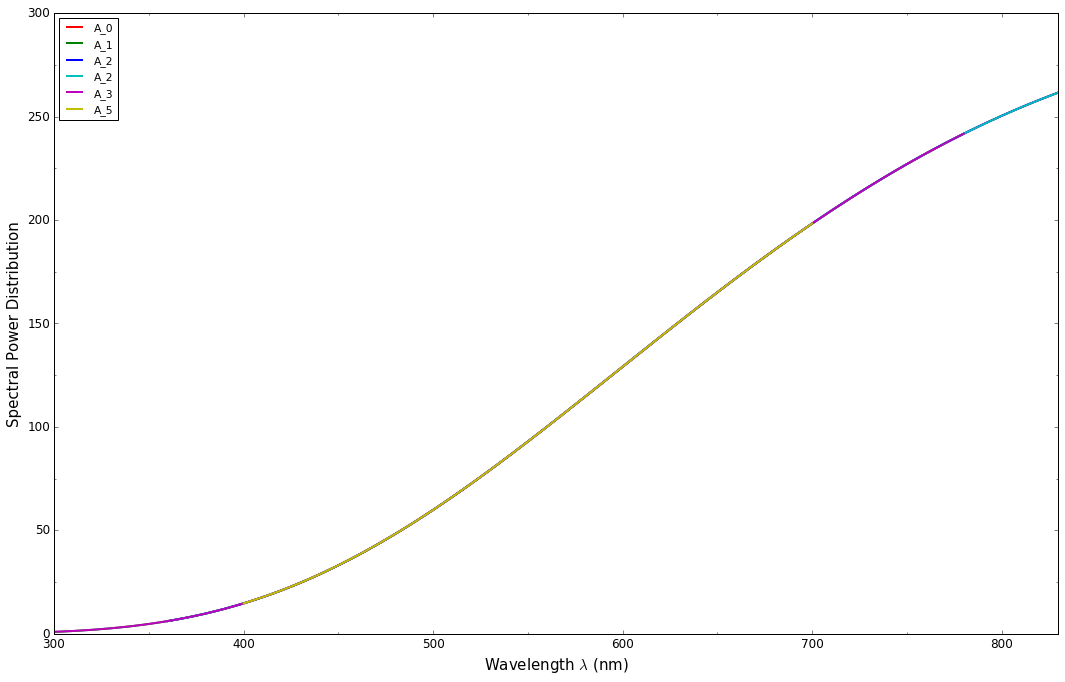

In [2]:
multi_spd_plot([A_0, A_1, A_2, A_3, A_4, A_5])

In [3]:
def tristimulus_weighting_factors_ASTME2022(cmfs, illuminant, shape):
    # Assumes that the measurement interval is equal to the spectral bandwidth integral when applying correction
    # for bandwidth.
    if cmfs.shape.steps != 1:
        raise RuntimeError('"{0}" shape "steps" must be 1!'.format(cmfs))

    if illuminant.shape.steps != 1:
        raise RuntimeError('"{0}" shape "steps" must be 1!'.format(illuminant))

    global _TRISTIMULUS_WEIGHTING_FACTORS_CACHE
    if _TRISTIMULUS_WEIGHTING_FACTORS_CACHE is None:
        _TRISTIMULUS_WEIGHTING_FACTORS_CACHE = CaseInsensitiveMapping()

    name_twf = ', '.join((cmfs.name, illuminant.name, str(shape)))
    if name_twf in _TRISTIMULUS_WEIGHTING_FACTORS_CACHE:
        return _TRISTIMULUS_WEIGHTING_FACTORS_CACHE[name_twf]

    Y = cmfs.values
    S = illuminant.values

    W = S[::shape.steps, np.newaxis] * Y[::shape.steps, :]

    # First and last measurement intervals Lagrange interpolating coefficients.
    c_c = lagrange_interpolating_coefficients_ASTME2022(
            shape.steps, 'boundaries')
    # Intermediate measurement intervals Lagrange interpolating coefficients.
    c_b = lagrange_interpolating_coefficients_ASTME2022(
            shape.steps, 'intermediate')

    # Total wavelengths count.
    w_c = len(Y)
    # Measurement interval interpolated values count.
    r_c = c_b.shape[0]
    # Last interval first interpolated wavelength.
    w_lif = w_c - (w_c - 1) % shape.steps - 1 - r_c

    # Intervals count.
    i_c = W.shape[0]
    i_cm = i_c - 1

    for i in range(3):
        # First interval.
        for j in range(r_c):
            for k in range(3):
                W[k, i] = W[k, i] + c_c[j, k] * S[j + 1] * Y[j + 1, i]

        # Last interval.
        for j in range(r_c):
            for k in range(i_cm, i_cm - 3, -1):
                W[k, i] = (W[k, i] + c_c[r_c - j - 1, i_cm - k] *
                           S[j + w_lif] * Y[j + w_lif, i])

        # Intermediate intervals.
        for j in range(i_c - 3):
            for k in range(r_c):
                w_i = (r_c + 1) * (j + 1) + 1 + k
                W[j, i] = W[j, i] + c_b[k, 0] * S[w_i] * Y[w_i, i]
                W[j + 1, i] = W[j + 1, i] + c_b[k, 1] * S[w_i] * Y[w_i, i]
                W[j + 2, i] = W[j + 2, i] + c_b[k, 2] * S[w_i] * Y[w_i, i]
                W[j + 3, i] = W[j + 3, i] + c_b[k, 3] * S[w_i] * Y[w_i, i]

        # Extrapolation of incomplete interval.
        for j in range(int(w_c - ((w_c - 1) % shape.steps)), w_c, 1):
            W[i_cm, i] = W[i_cm, i] + S[j] * Y[j, i]

    W *= 100 / np.sum(W, axis=0)[1]
    
    _TRISTIMULUS_WEIGHTING_FACTORS_CACHE[name_twf] = W

    return W


steps = 10
W = tristimulus_weighting_factors_ASTME2022(
        CMFS, A_0, SpectralShape(360, 830, steps))
pd.DataFrame(np.round(W, 3), index=CMFS.wavelengths[::steps])

/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,0,1,2
360,-0.000,-0.000,-0.000
370,-0.000,-0.000,-0.000
380,-0.000,-0.000,-0.000
390,0.002,0.000,0.008
400,0.025,0.003,0.110
410,0.134,0.014,0.615
420,0.377,0.039,1.792
430,0.686,0.084,3.386
440,0.964,0.156,4.944
450,1.080,0.259,5.806


In [4]:
print(_TRISTIMULUS_WEIGHTING_FACTORS_CACHE.keys())
print(_TRISTIMULUS_WEIGHTING_FACTORS_CACHE[
    'CIE 1964 10 Degree Standard Observer, A_0, (360.0, 830.0, 10.0)'])

[u'CIE 1964 10 Degree Standard Observer, A_0, (360.0, 830.0, 10.0)']
[[ -0.00000107  -0.00000012  -0.00000472]
 [ -0.00001661  -0.00000178  -0.00007381]
 [ -0.00006265  -0.00000599  -0.00029594]
 [  0.00173203   0.00019067   0.00750329]
 [  0.02462197   0.00258221   0.11002471]
 [  0.13380791   0.01362493   0.61486115]
 [  0.37667958   0.03938975   1.79237892]
 [  0.68597339   0.0841476    3.3861349 ]
 [  0.96392708   0.15560923   4.9435215 ]
 [  1.07974419   0.25937514   5.80554508]
 [  1.00590861   0.42435443   5.81195103]
 [  0.73080637   0.69621402   4.91946293]
 [  0.34300924   1.0820871    3.29990629]
 [  0.07831511   1.61594792   1.97254698]
 [  0.02194756   2.42211921   1.15160362]
 [  0.21833481   3.52935836   0.65817752]
 [  0.74977436   4.83960641   0.38208014]
 [  1.64205871   6.09952855   0.21088813]
 [  2.84155576   7.24966561   0.1017075 ]
 [  4.33599624   8.11420343   0.03166653]
 [  6.19979323   8.75836777   0.00075805]
 [  8.26209852   8.98754929  -0.00039173]
 [ 10.2

In [5]:
def reshape_tristimulus_weighting_factors_ASTME2022(W, shape_W, shape_R):
    W = np.copy(W)

    start_index = int((shape_R.start - shape_W.start) / shape_W.steps)
    for i in range(start_index):
        W[start_index] += W[i]

    end_index = int((shape_W.end - shape_R.end) / shape_W.steps)
    for i in range(end_index):
        W[-end_index - 1] += W[-i - 1]
    
    return W[start_index:-end_index or None, ...]

W = _TRISTIMULUS_WEIGHTING_FACTORS_CACHE[
    'CIE 1964 10 Degree Standard Observer, A_0, (360.0, 830.0, 10.0)']

reshape_tristimulus_weighting_factors_ASTME2022(
        W, SpectralShape(360, 830, 10), SpectralShape(360, 830, 10))

array([[ -0.00000107,  -0.00000012,  -0.00000472],
       [ -0.00001661,  -0.00000178,  -0.00007381],
       [ -0.00006265,  -0.00000599,  -0.00029594],
       [  0.00173203,   0.00019067,   0.00750329],
       [  0.02462197,   0.00258221,   0.11002471],
       [  0.13380791,   0.01362493,   0.61486115],
       [  0.37667958,   0.03938975,   1.79237892],
       [  0.68597339,   0.0841476 ,   3.3861349 ],
       [  0.96392708,   0.15560923,   4.9435215 ],
       [  1.07974419,   0.25937514,   5.80554508],
       [  1.00590861,   0.42435443,   5.81195103],
       [  0.73080637,   0.69621402,   4.91946293],
       [  0.34300924,   1.0820871 ,   3.29990629],
       [  0.07831511,   1.61594792,   1.97254698],
       [  0.02194756,   2.42211921,   1.15160362],
       [  0.21833481,   3.52935836,   0.65817752],
       [  0.74977436,   4.83960641,   0.38208014],
       [  1.64205871,   6.09952855,   0.21088813],
       [  2.84155576,   7.24966561,   0.1017075 ],
       [  4.33599624,   8.11420

In [6]:
def spectral_to_XYZ_ASTM_E30815(spd,
                                cmfs=STANDARD_OBSERVERS_CMFS.get(
                                    'CIE 1931 2 Degree Standard Observer'),
                                illuminant=ones_spd(STANDARD_OBSERVERS_CMFS.get(
                                    'CIE 1931 2 Degree Standard Observer').shape)):
    print('*' * 79)
    print(spd.name, spd.shape)
    
    if spd.shape.steps == 1:
        if spd.shape != cmfs.shape:
            spd = spd.clone().align(cmfs.shape)
        
        S = illuminant.values
        x_bar, y_bar, z_bar = tsplit(cmfs.values)
        R = spd.values
    
        k = 100 / np.sum(y_bar * S)
    
        X_p = R * x_bar * S
        Y_p = R * y_bar * S
        Z_p = R * z_bar * S

        XYZ = k * np.array([np.sum(X_p), np.sum(Y_p), np.sum(Z_p)])
    elif spd.shape.steps in (5, 10):
        if (cmfs.shape.start != spd.shape.start or 
            cmfs.shape.end != spd.shape.end):
            spd = spd.clone().trim(cmfs.shape)

        W = tristimulus_weighting_factors_ASTME2022(
            cmfs, illuminant, SpectralShape(steps=spd.shape.steps))
        start_w = cmfs.shape.start
        end_w = cmfs.shape.start + spd.shape.steps * (W.shape[0] - 1)
        W = reshape_tristimulus_weighting_factors_ASTME2022(
            W, SpectralShape(start_w, end_w, spd.shape.steps), spd.shape)
        R = spd.values

        XYZ = np.sum(W * R[..., np.newaxis], axis=0)

    return XYZ

XYZ_A_0 = spectral_to_XYZ_ASTM_E30815(A_0, CMFS) / 100
XYZ_A_1 = spectral_to_XYZ_ASTM_E30815(A_1, CMFS) / 100
XYZ_A_2 = spectral_to_XYZ_ASTM_E30815(A_2, CMFS) / 100
XYZ_A_3 = spectral_to_XYZ_ASTM_E30815(A_3, CMFS) / 100
XYZ_A_4 = spectral_to_XYZ_ASTM_E30815(A_4, CMFS) / 100

print('\n')

print(colour.delta_E_CIE2000(colour.XYZ_to_Lab(XYZ_A_0), colour.XYZ_to_Lab(XYZ_A_1)))
print(colour.delta_E_CIE2000(colour.XYZ_to_Lab(XYZ_A_0), colour.XYZ_to_Lab(XYZ_A_2)))
print(colour.delta_E_CIE2000(colour.XYZ_to_Lab(XYZ_A_0), colour.XYZ_to_Lab(XYZ_A_3)))
print(colour.delta_E_CIE2000(colour.XYZ_to_Lab(XYZ_A_0), colour.XYZ_to_Lab(XYZ_A_4)))

print('\n')

print(_TRISTIMULUS_WEIGHTING_FACTORS_CACHE.keys())

# 0.000643086073273
# 0.000720553331383
# 4.86633069299e-05
# 5.07225469815e-05


*******************************************************************************
('A_0', SpectralShape(360.0, 830.0, 1.0))
*******************************************************************************
('A_1', SpectralShape(300.0, 780.0, 5.0))
*******************************************************************************
('A_2', SpectralShape(360.0, 830.0, 5.0))
*******************************************************************************
('A_2', SpectralShape(360.0, 830.0, 10.0))
*******************************************************************************
('A_3', SpectralShape(300.0, 780.0, 10.0))


8.16202686378e-05
2.96293085294e-06
4.86633069299e-05
5.07225469815e-05


[u'CIE 1964 10 Degree Standard Observer, A_0, (360.0, 830.0, 10.0)', u'CIE 1964 10 Degree Standard Observer, 1 Constant, (None, None, 5.0)', u'CIE 1964 10 Degree Standard Observer, 1 Constant, (None, None, 10.0)']


/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
